# LCLUC Random Forest

In [1]:
# Import packages
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rioxr
import xarray as xr
import rasterstats
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pd.set_option('display.max_columns', None)


In [2]:
# Read in data
wrk_dir = Path.cwd().parent # go up a directory with parent
data_path = os.path.join(wrk_dir, 'data')

# Labels
all_label_data = pd.read_parquet(os.path.join(data_path, 'all_label_data.parquet'))

# Rasters - open as Dataset first
rasters_ds = xr.open_dataset(os.path.join(data_path, 'rasters_stack.nc'))

# Check what variables are in the dataset
print("Variables in dataset:", list(rasters_ds.data_vars))
# We want the second item in this list

Variables in dataset: ['spatial_ref', '__xarray_dataarray_variable__']


In [3]:
# Extract the main data variable
rasters = rasters_ds['__xarray_dataarray_variable__']
# rasters = rasters_ds[list(rasters_ds.data_vars)[0]]

print(f"Loaded {len(rasters.band)} bands")
print(f"Bands: {rasters.band.values}")

Loaded 50 bands
Bands: ['coastal_areosol_L30' 'blue_L30' 'green_L30' 'red_L30' 'NIR_narrow_L30'
 'SWIR1_L30' 'SWIR2_L30' 'cirrus_L30' 'TIR1_L30' 'TIR2_L30'
 'coastal_areosol_S30' 'blue_S30' 'green_S30' 'red_S30' 'red_edge_1_S30'
 'red_edge_2_S30' 'red_edge_3_S30' 'NIR_broad_S30' 'NIR_narrow_S30'
 'SWIR1_S30' 'SWIR2_S30' 'water_vapor_S30' 'cirrus_S30' 'blue_evi_l30'
 'blue_evi_s30' 'VV' 'VH' 'VV_VH' 'dem_band_0' 'dem_band_1' 'dem_band_2'
 'dem_band_3' 'dem_band_4' 'dem_band_5' 'GLCM_mean_red'
 'GLCM_variance_red' 'GLCM_homogeneity_red' 'GLCM_contrast_red'
 'GLCM_dissimilarity_red' 'GLCM_entropy_red' 'GLCM_second_moment_red'
 'GLCM_correlation_red' 'GLCM_mean_nir' 'GLCM_variance_nir'
 'GLCM_homogeneity_nir' 'GLCM_contrast_nir' 'GLCM_dissimilarity_nir'
 'GLCM_entropy_nir' 'GLCM_second_moment_nir' 'GLCM_correlation_nir']


In [4]:
# Create data set with only forest and non-forest labels 
def subset_labels(df, classes):
    """
    Create dataset with specified classes, combining all others as 'nonforest'
    """
    # Create a copy to avoid modifying original
    subset = df.copy()
    
    # Replace class values: keep if in classes list, otherwise set to 'nonforest'
    subset['class'] = subset['class'].apply(
        lambda x: x if x in classes else 'nonforest'
    )
    
    # Convert class column to categorical
    subset['class'] = subset['class'].astype('category')
    
    return subset

forest = subset_labels(all_label_data, ['forest'])
forest_water_bare = subset_labels(all_label_data, ['forest', 'water', 'bare'])

In [4]:
print(f"{all_label_data['class'].value_counts()}\n")
print(all_label_data['class'].value_counts())

class
bare           270
forest         270
built          260
agriculture    260
oil_palm       150
water           90
Name: count, dtype: int64

class
bare           270
forest         270
built          260
agriculture    260
oil_palm       150
water           90
Name: count, dtype: int64


For the forest/non-forest, definitely have a class imbalance that should be considered in the model design...

In [ ]:
forest.isna().sum()

class                      0
coastal_areosol_L30       19
blue_L30                  19
green_L30                 19
red_L30                   19
NIR_narrow_L30            19
SWIR1_L30                 19
SWIR2_L30                 19
cirrus_L30                19
TIR1_L30                  19
TIR2_L30                  19
coastal_areosol_S30        0
blue_S30                   0
green_S30                  0
red_S30                    0
red_edge_1_S30             0
red_edge_2_S30             0
red_edge_3_S30             0
NIR_broad_S30              0
NIR_narrow_S30             0
SWIR1_S30                  0
SWIR2_S30                  0
water_vapor_S30            0
cirrus_S30                 0
blue_evi_l30              19
blue_evi_s30               0
VV                         0
VH                         0
VV_VH                      0
dem_band_0                 0
dem_band_1                 0
dem_band_2                 0
dem_band_3                 0
dem_band_4                 0
dem_band_5    

## Model Design

In [5]:
# Impute missing values
# forest_clean = forest.drop(columns=['GLCM_correlation_nir', 'GLCM_contrast_red'])

# Separate features and target
X = all_label_data.drop(columns=['class'])
y = all_label_data['class']

# Scale to avoid warnings when imputing
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Impute remaining NAs using KNN
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X_scaled), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42, stratify=y)  # Ensures both train/test have same class ratios


Here is where you can add more parameters and vary the ranges of the parameters. This is just a few to get started, but there are many more you can add and also other ways of optimizing a parameter grid beyond a grid search

In [22]:
# Parameter search
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    # verbose=2
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [10, 20, 30],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [100, 300, 500]},
             scoring='f1_weighted')

In [23]:
# See what the best parameter selections were
grid_search.best_params_

{'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_split': 10,
 'n_estimators': 500}

In [24]:
# Initiate model with best parameters
best_rf_model = RandomForestClassifier(
    **grid_search.best_params_,
    n_jobs=-1,
    random_state = 808
)

In [25]:
# Fit model
best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}\n")
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

 agriculture       0.95      0.95      0.95        78
        bare       0.89      0.94      0.92        81
       built       0.95      0.88      0.91        78
      forest       1.00      1.00      1.00        81
    oil_palm       0.98      1.00      0.99        45
       water       1.00      1.00      1.00        27

    accuracy                           0.95       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.95      0.95      0.95       390


Confusion matrix:
[[74  4  0  0  0  0]
 [ 0 76  4  0  1  0]
 [ 4  5 69  0  0  0]
 [ 0  0  0 81  0  0]
 [ 0  0  0  0 45  0]
 [ 0  0  0  0  0 27]]

Accuracy score: 0.9538


In [26]:
# Feature Importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

                feature  importance
20            SWIR2_S30    0.073182
26                   VH    0.070320
14       red_edge_1_S30    0.064101
5             SWIR1_L30    0.063268
21      water_vapor_S30    0.056622
27                VV_VH    0.049546
6             SWIR2_L30    0.049307
12            green_S30    0.044765
13              red_S30    0.042282
25                   VV    0.039340
11             blue_S30    0.038764
10  coastal_areosol_S30    0.036965
0   coastal_areosol_L30    0.033268
2             green_L30    0.031488
16       red_edge_3_S30    0.029450
15       red_edge_2_S30    0.026904
17        NIR_broad_S30    0.026722
24         blue_evi_s30    0.026298
18       NIR_narrow_S30    0.024262
22           cirrus_S30    0.023422


In [ ]:
# rasters_subset = rasters.drop_sel(band=['GLCM_correlation_nir', 'GLCM_contrast_red'])


In [27]:
# Stack rasters into numpy array
raster_stack = rasters.values  # shape: (bands, y, x)
n_bands, height, width = raster_stack.shape

# Reshape to (n_pixels, n_bands)
raster_2d = raster_stack.reshape(n_bands, -1).T


In [28]:
# Convert to DataFrame with proper column names
raster_df = pd.DataFrame(raster_2d, columns=rasters.band.values)

# Apply same scaling transformation used during training
raster_scaled = pd.DataFrame(
    scaler.transform(raster_df),
    columns=raster_df.columns
)

# Impute NAs in raster data
raster_imputed = pd.DataFrame(
    imputer.transform(raster_scaled), 
    columns=raster_scaled.columns
)


In [29]:
# Chunk for efficiency
chunk_size = 100000
predictions = []

for i in range(0, len(raster_imputed), chunk_size):
    chunk = raster_imputed.iloc[i:i+chunk_size]
    pred_chunk = best_rf_model.predict(chunk)
    predictions.extend(pred_chunk)

predictions = np.array(predictions)


In [30]:
# Recode to Numeric
label_map = {'forest': 1, 'water': 2, 'bare': 3, 'agriculture': 4, 'built': 5, 'oil_palm': 6, 'nonforest': 0}
predictions_numeric = np.array([label_map.get(p, -1) for p in predictions])

# Reshape back to raster dimensions
prediction_raster = predictions_numeric.reshape(height, width)

# Handle NaN values - set to a nodata value
prediction_raster = prediction_raster.astype(float)  # Keep as float to preserve NaN
nodata_value = -9999
prediction_raster = np.where(np.isnan(prediction_raster), nodata_value, prediction_raster)


In [31]:
# Prep for output
output = rasters.isel(band=0).copy()  # Template from first band
output.values = prediction_raster

# Clear all attributes and set only what's needed
output.attrs = {}
output.attrs['long_name'] = 'forest_prediction'

# Set nodata value
# output.rio.write_nodata(nodata_value, inplace=True)

# Write out tif
# output.rio.to_raster(os.path.join(data_path, 'output', 'forest_prediction.tif'))

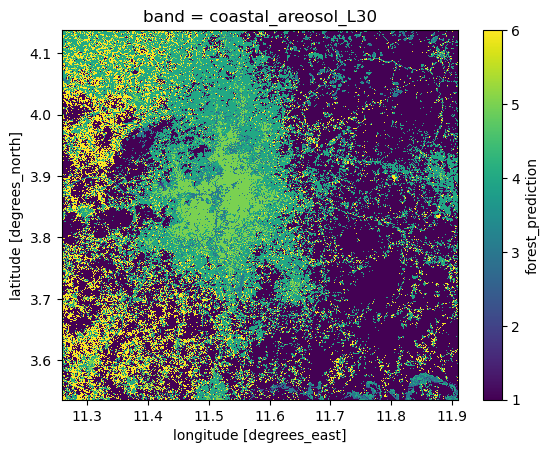

In [ ]:
output.plot()
label_map = {'forest': 1, 'water': 2, 'bare': 3, 'agriculture': 4, 'built': 5, 'oil_palm': 6, 'nonforest': 0}

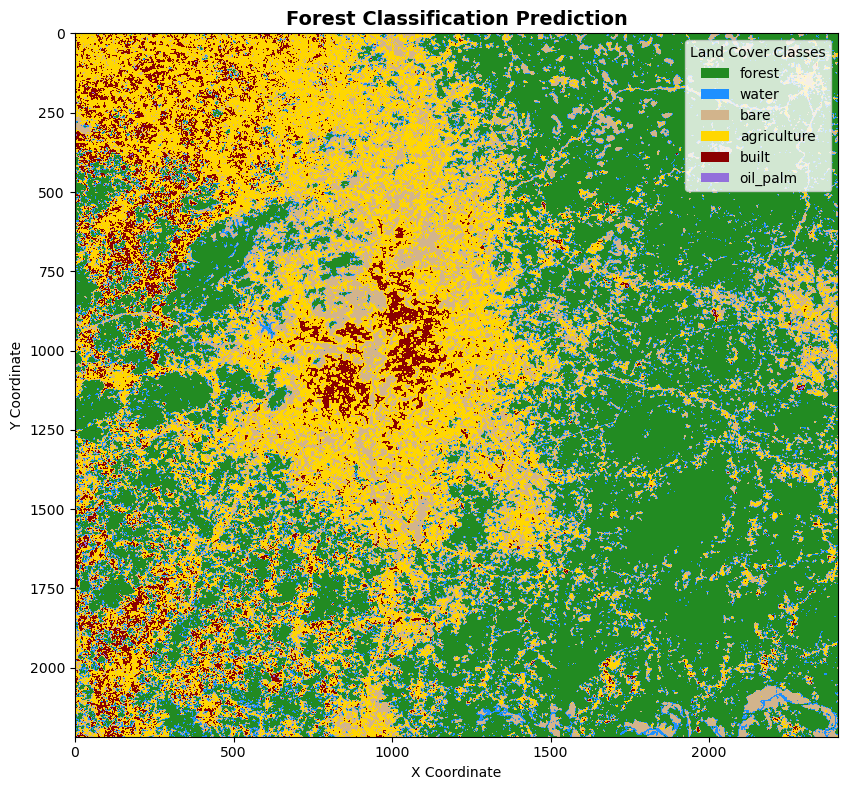

In [32]:
import matplotlib.colors as mcolors

# Define label map
label_map = {'forest': 1, 'water': 2, 'bare': 3, 'agriculture': 4, 'built': 5, 'oil_palm': 6, 'nonforest': 0}

# Create reverse mapping (value to label)
value_to_label = {v: k for k, v in label_map.items()}
value_to_label[-9999] = 'nodata'  # Add nodata category

# Define colors for each class
colors = {
    0: '#d3d3d3',      # nonforest - light gray
    1: '#228B22',      # forest - forest green
    2: '#1E90FF',      # water - dodger blue
    3: '#D2B48C',      # bare - tan
    4: '#FFD700',      # agriculture - gold
    5: '#8B0000',      # built - dark red
    6: '#9370DB',      # oil_palm - medium purple
    -9999: '#000000'   # nodata - black
}

# Get unique values in prediction raster
unique_values = np.unique(prediction_raster)
unique_values = unique_values[unique_values != -9999]  # Exclude nodata from main categories

# Create colormap
cmap = mcolors.ListedColormap([colors[val] for val in sorted(unique_values)])
boundaries = sorted(unique_values) + [max(unique_values) + 1]
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(prediction_raster, cmap=cmap, norm=norm)

# Create legend
legend_labels = [value_to_label[val] for val in sorted(unique_values)]
legend_colors = [colors[val] for val in sorted(unique_values)]

# Create custom legend patches
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=legend_colors[i], label=legend_labels[i]) 
                   for i in range(len(legend_labels))]

ax.legend(handles=legend_elements, loc='upper right', title='Land Cover Classes')
ax.set_title('Forest Classification Prediction', fontsize=14, fontweight='bold')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

plt.tight_layout()
plt.show()